In [2]:
import pandas as pd
import numpy as np
from prophet import Prophet

In [3]:
crime = pd.read_csv("Data/NYPD_Complaint_Folium.csv")
crime.head()

,id,start_date_of_event,start_time_of_event,description,boro,lat,lon,victim_age,victim_race,victim_sex,month,day,year
0,134037758,12/26/2019,20:00:00,Petit Larceny,Queens,40.611570,-73.747365,25-44,White Hispanic,F,12,26,2019
1,855385879,12/26/2019,19:57:00,Offenses Against Public Order,Bronx,40.840234,-73.917684,18-24,Black,F,12,26,2019
2,241602326,12/25/2019,23:00:00,Petit Larceny,Manhattan,40.772875,-73.989542,45-64,Black,M,12,25,2019
3,249276017,12/20/2019,14:00:00,Felony Assault,Bronx,40.822271,-73.911698,<18,Black Hispanic,M,12,20,2019
4,636997863,12/20/2019,22:18:00,Reckless Assault,Bronx,40.863223,-73.890411,18-24,Black,F,12,20,2019


In [31]:
crime.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4012179 entries, 0 to 4012178
Data columns (total 13 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   id                   4012179 non-null  int64         
 1   start_date_of_event  4012179 non-null  datetime64[ns]
 2   start_time_of_event  4012179 non-null  object        
 3   description          4012179 non-null  object        
 4   boro                 4009205 non-null  object        
 5   lat                  4012179 non-null  float64       
 6   lon                  4012179 non-null  float64       
 7   victim_age           4012179 non-null  object        
 8   victim_race          4012179 non-null  object        
 9   victim_sex           4012179 non-null  object        
 10  month                4012179 non-null  int64         
 11  day                  4012179 non-null  int64         
 12  year                 4012179 non-null  int64         
dt

In [4]:
crime["start_date_of_event"] = pd.to_datetime(crime["start_date_of_event"])

In [5]:
def slice_df(boro, age, race, sex):
    df = crime[(crime["boro"] == boro) & (crime["victim_age"] == age) & (crime["victim_race"] == race) & 
               (crime["victim_sex"] == sex)]
    return df

In [6]:
crime_sliced = slice_df("Staten Island", "18-24", "Black", "M")

In [7]:
crime_daily = crime_sliced.groupby(["start_date_of_event"]).agg({"id":"count"}).reset_index()

In [8]:
crime_daily.columns = ["ds", "y"]

In [11]:
crime_monthly = crime_sliced.groupby(["year", "month"]).agg({"id":"count"}).reset_index()
crime_monthly

,year,month,id
0,2006,1,11
1,2006,2,6
2,2006,3,8
3,2006,4,7
4,2006,5,10
...,...,...,...
187,2021,8,5
188,2021,9,11
189,2021,10,10
190,2021,11,12


In [12]:
crime_monthly["year"] = crime_monthly["year"].astype("str")

In [13]:
crime_monthly["month"] = crime_monthly["month"].astype("str")

In [14]:
crime_monthly["ds"] = pd.DatetimeIndex(crime_monthly["year"] + "-" + crime_monthly["month"])

In [15]:
crime_monthly.drop(columns = ["year", "month"], inplace = True)

In [16]:
crime_monthly.columns = ["y", "ds"]

In [17]:
crime_monthly

,y,ds
0,11,2006-01-01
1,6,2006-02-01
2,8,2006-03-01
3,7,2006-04-01
4,10,2006-05-01
...,...,...
187,5,2021-08-01
188,11,2021-09-01
189,10,2021-10-01
190,12,2021-11-01


In [18]:
model = Prophet(interval_width = 0.9)
trained = model.fit(crime_daily)

08:39:52 - cmdstanpy - INFO - Chain [1] start processing
08:39:53 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
future = model.make_future_dataframe(periods = 730, freq = "D")
forecast = model.predict(future)

In [20]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2432,2023-12-23,1.182709,0.375952,2.039203,1.180583,1.185233,-0.007563,-0.007563,-0.007563,-0.022071,-0.022071,-0.022071,0.014508,0.014508,0.014508,0.0,0.0,0.0,1.175146
2433,2023-12-24,1.182682,0.315318,2.016175,1.180552,1.185215,0.004827,0.004827,0.004827,-0.009555,-0.009555,-0.009555,0.014382,0.014382,0.014382,0.0,0.0,0.0,1.187509
2434,2023-12-25,1.182655,0.420560,2.076024,1.180522,1.185197,0.056379,0.056379,0.056379,0.040836,0.040836,0.040836,0.015543,0.015543,0.015543,0.0,0.0,0.0,1.239035
2435,2023-12-26,1.182629,0.372767,2.051391,1.180491,1.185179,0.047529,0.047529,0.047529,0.029625,0.029625,0.029625,0.017903,0.017903,0.017903,0.0,0.0,0.0,1.230157
2436,2023-12-27,1.182602,0.372464,2.042248,1.180460,1.185161,-0.013670,-0.013670,-0.013670,-0.035010,-0.035010,-0.035010,0.021340,0.021340,0.021340,0.0,0.0,0.0,1.168932


In [21]:
model_month = Prophet(interval_width = 0.9)
trained_month = model_month.fit(crime_monthly)

08:39:54 - cmdstanpy - INFO - Chain [1] start processing
08:39:54 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
future_month = model_month.make_future_dataframe(periods = 24, freq = "M")
forecast_month = model_month.predict(future_month)

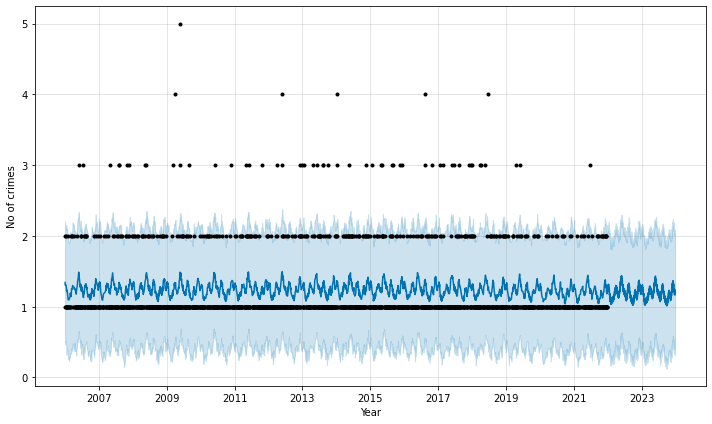

In [23]:
plot = model.plot(forecast, xlabel = "Year", ylabel = "No of crimes")

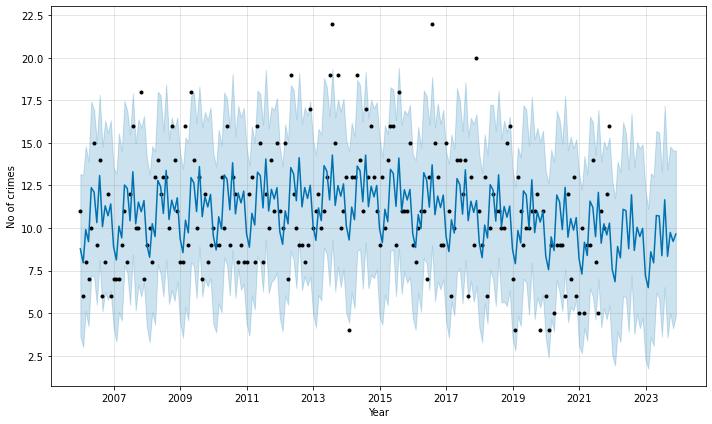

In [24]:
plot_month = model_month.plot(forecast_month, xlabel = "Year", ylabel = "No of crimes")

In [25]:
pd.DataFrame(crime["description"].value_counts())

,description
Reckless Assault,757590
Petit Larceny,735459
Grand Larceny,530179
Criminal Mischief,462591
Offenses Against Public Order,349614
Felony Assault,269625
Robbery,236209
Burglary,167868
Miscellaneous Penal Law,124794
Grand Larceny Of Motor Vehicle,119339
